In [6]:
import os
from PIL import Image
import pandas as pd
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline
vectorized_images = []
directory = os.fsencode('train/')
labels = 0
image_titles = []
with open('train/train_labels.csv', 'r') as labels:
    labels = pd.read_csv(labels)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.tif'):
        with Image.open('train/' + filename).convert('L') as image:
            image_titles.append(filename[:-4])
            vectorized_images.append(np.asarray(image).reshape(9216))


(9216,)


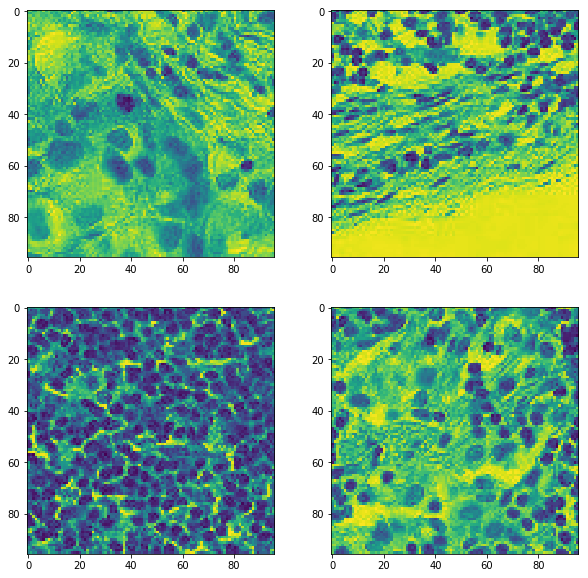

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for idx in range(4):
    fig.add_subplot(2,2,idx+1)
    imshow(vectorized_images[idx].reshape((96,96)))
print(vectorized_images[0].shape)

In [8]:
# vec_images = vectorized_images[0]
import gc
vec_images = np.zeros((10000,9216))

for idx, img in enumerate(vectorized_images[:10000]):
    vec_images[idx,:] = img

vec_images_fl32 = vec_images.astype(np.float32)
vectorized_images = []
gc.collect()

58

In [23]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

n_comp = 3000
pca = PCA(n_components=n_comp)
pca.fit_transform(vec_images)


kpca = KernelPCA(n_components= n_comp, kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit(vec_images)


In [13]:
print(sum(pca.explained_variance_ratio_) * 100, '% of variance explained')

94.86280866612879 % of variance explained


(3000, 9216)


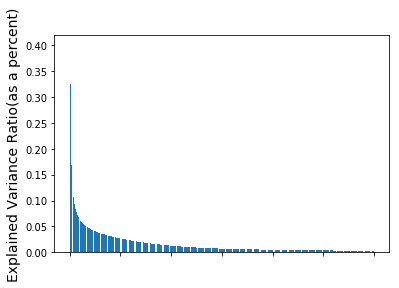

In [14]:
fig,ax = plt.subplots(1)
ax.set_xticklabels([])
plt.ylabel('Explained Variance Ratio(as a percent)', fontsize=14)
plt.ylim([0,max(pca.explained_variance_ratio_)])
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_*100)

print(pca.components_.shape)

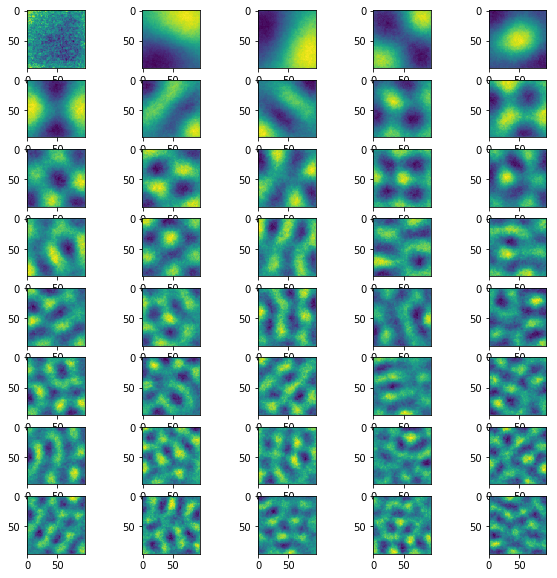

In [15]:
eigencells = pca.components_.reshape((n_comp, 96, 96))
fig = plt.figure(figsize=(10,10))
for idx in range(40):
    fig.add_subplot(8, 5,idx+1)
    imshow(eigencells[idx])

SSIM for reconstruction of cancerous samples with normal PCA 0.8319454299246766
SSIM for reconstruction of noncancerous samples with normal PCA 0.7499248226960626
SSIM for reconstruction of cancerous samples with kernel PCA 0.6769082114336726
SSIM for reconstruction of noncancerous samples with kernel PCA 0.6201876635082116


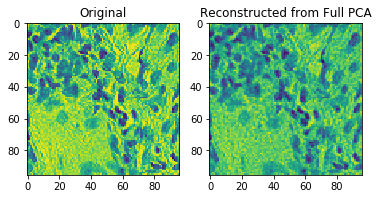

In [36]:
from skimage.measure import compare_ssim as ssim
#helper function to reconstruct image sourced from class jupyter notebook
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

def reconstruct_by_prediction_class(trans_obj, pred_class):
    img_names = labels[labels.label == pred_class]
    ssim_values = []
    for index, row in img_names.head(1000).iterrows():
        try:
            idx_to_reconstruct = image_titles[:10000].index(row.id)
            X_idx = vec_images[idx_to_reconstruct]
            low_dim_rep, reconstructed_img = reconstruct_image(trans_obj, X_idx.reshape(1,-1))
            ssim_values.append(ssim(X_idx.reshape(96,96), reconstructed_img.reshape(96,96)))
        except Exception as e:
            pass
    return sum(ssim_values)/len(ssim_values)
        
idx_to_reconstruct = 4 
X_idx = vec_images[idx_to_reconstruct]
low_dim_rep, reconstructed_img = reconstruct_image(pca,X_idx.reshape(1,-1))

plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((96,96)))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_img.reshape((96,96)))
plt.title('Reconstructed from Full PCA')

print("SSIM for reconstruction of cancerous samples with normal PCA",reconstruct_by_prediction_class(pca, 1))
print("SSIM for reconstruction of noncancerous samples with normal PCA",reconstruct_by_prediction_class(pca, 0))

print("SSIM for reconstruction of cancerous samples with kernel PCA",reconstruct_by_prediction_class(X_kpca, 1))
print("SSIM for reconstruction of noncancerous samples with kernel PCA",reconstruct_by_prediction_class(X_kpca, 0))
